In [1]:
import os
os.environ["KERAS_BACKEND"] = "torch"
import keras
import pandas as pd
from pyprojroot import here
import numpy as np

test_pd = pd.read_csv(here(r"data/sign_language_mnist/sign_mnist_test.csv"))
train_pd = pd.read_csv(here(r"data/sign_language_mnist/sign_mnist_train.csv"))
test_pd

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,...,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,...,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,...,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,...,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,...,26,40,64,48,29,46,49,46,46,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7167,1,135,119,108,102,105,99,61,103,121,...,108,112,116,114,118,180,184,176,167,163
7168,12,157,159,161,164,166,166,171,174,175,...,213,213,213,214,213,211,210,210,209,208
7169,2,190,191,190,191,190,190,192,192,191,...,216,215,213,214,214,213,210,211,209,208
7170,4,201,205,208,209,214,216,218,223,226,...,112,169,255,255,237,113,91,67,70,63


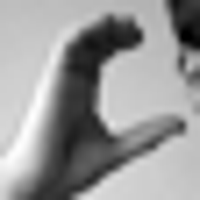

In [2]:
# remove label
train_label = train_pd["label"].to_numpy()
test_label = test_pd["label"].to_numpy()

train = train_pd.drop(columns=["label"]).to_numpy().reshape(-1, 28, 28, 1) # obs, width, height, channels
test = test_pd.drop(columns=["label"]).to_numpy().reshape(-1, 28, 28, 1)
keras.utils.array_to_img(train[2]).resize((200, 200))

In [8]:
from keras import layers
from tqdm.keras import TqdmCallback

class MLP:
  def __init__(self, epochs=10, batch_size=32, lr=0.01, seed=None, validation_split=0.2):
    self.epochs = epochs
    self.batch_size = batch_size
    self.lr = lr
    self.validation_split = validation_split
    self.__make_model(seed)
  def __make_model(self, seed=None):
    if seed is not None: keras.utils.set_random_seed(seed)
    self.model = keras.Sequential([
      layers.Input(shape=(28, 28, 1)),
      layers.Flatten(),
      layers.Rescaling(1./255),
      layers.Dense(2**9, activation="relu"),
      layers.Dense(2**8, activation="relu"),
      layers.Dense(2**7, activation="relu"),
      layers.Dense(2**6, activation="relu"),
      layers.Dense(26,   activation="softmax")
    ])
    self.model.compile(
      loss="sparse_categorical_crossentropy",
      optimizer=keras.optimizers.SGD(learning_rate=self.lr),
      metrics=["accuracy"]
    )
      
  def summary(self):
    return self.model.summary()
  
  def fit(self, x, y, reset=True, seed=None):
    if seed is not None: keras.utils.set_random_seed(seed)
    if reset:
      self.__make_model()
    history = self.model.fit(
      x, y,
      batch_size=self.batch_size,
      epochs=self.epochs,
      validation_split=0 if self.validation_split is None else self.validation_split,
      verbose=0,
      callbacks=[
        TqdmCallback(verbose=1),
        keras.callbacks.EarlyStopping(
          monitor="val_loss",
          patience=5,
          restore_best_weights=True
        )
      ])
    return pd.DataFrame(history.history)
    
MLP().summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_5 (Rescaling)         │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       401,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 26)             │         1,690 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 576,090 (2.20 MB)

 Trainable params: 576,090 (2.20 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
keras.utils.set_random_seed(42)
model = MLP()
history = model.fit(train, train_label)
history

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

,accuracy,loss,val_accuracy,val_loss
0,0.192224,2.807254,0.180659,2.669376
1,0.414587,1.876124,0.340011,1.894948
2,0.552723,1.380178,0.512657,1.397801
3,0.640184,1.107062,0.534329,1.375807
4,0.713213,0.884622,0.562921,1.336830
5,0.771171,0.706315,0.420506,2.086547
6,0.813240,0.581076,0.835367,0.504820
7,0.857312,0.449281,0.777818,0.670865
8,0.885540,0.384116,0.936077,0.240445
9,0.912994,0.305879,0.821526,0.513516


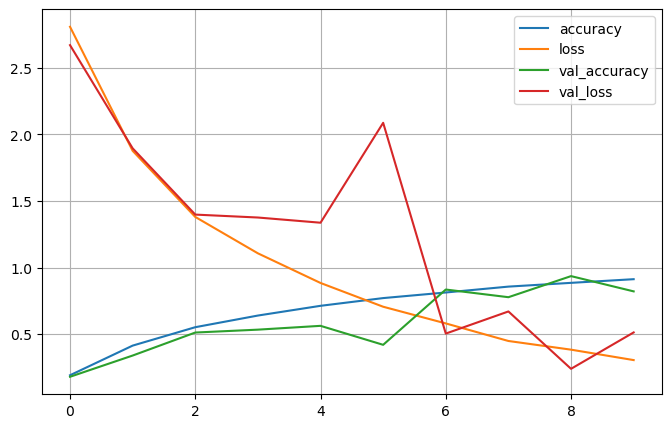

In [10]:
import matplotlib.pyplot as plt
history.plot(figsize=(8, 5), grid=True)
plt.show()